# Instructions:

1. Run import Statements and load in data
2. scroll down and run all helper functions code to lead them into the notebook
3. Begin to run analysis cells from top to bottom (AFTER you have imported/run helper functions)

### Data Structures Created:
- **spark_df:** main spark sql context dataframe holding all the data (minus 'labels' column)
- **df:** The main pandas dataframe, complete.
- **station_df:** Info about stations and a groupby count of station occurances.
- **year_data:** Dict of key = measureaments and values the vector years as numpy arrays
- **df_pca:** dataframe for pca analysis, general and holds all the data
- **USC00082220_prcp_meta_df:** all the mata data, including year vectors for this station for the percipitation measurement


## Import Libraries and Load Raw Data

In [344]:
import sys
sys.path.append('./lib')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
# sns.set_palette(palette="colorblind")
sns.set_palette(palette="muted")
from numpy_pack import packArray, unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
import sklearn as sk
import urllib
import math
%pylab inline
from YearPlotter import YearPlotter
from pickle import load

from ipyleaflet import (Map,
                        Marker,
                        TileLayer, 
                        ImageOverlay,
                        Polyline, 
                        Polygon, 
                        Rectangle, 
                        Circle, 
                        CircleMarker,
                        GeoJSON,
                        DrawControl)

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Circle', 'Rectangle', 'Polygon', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Setting up Spark Environment

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py',
                                             'lib/spark_PCA.py',
                                             'lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
### Read the data frame from pickle file

data_dir = '../../Data/Weather'
file_index = 'BSSSBSBS'

#read statistics from pickle file
filename = '{}/STAT_{}.pickle'.format(data_dir,file_index)
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT:',STAT.keys()

#read data from parquet file
filename = '{}/US_Weather_{}.parquet'.format(data_dir,file_index)

spark_df=sqlContext.read.parquet(filename)
print 'spark_df count: ',spark_df.count()
spark_df.show(3)

keys from STAT: ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
spark_df count:  12249
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     14.9| 30.4132| -86.6635|       PRCP|US1FLOK0014|    38|[00 00 00 00 B0 5...|2009.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     5|[40 5A F0 5A 80 5...|1999.0|BSSSBSBS|
|      6.4| 30.2119| -85.6828|       TMAX|USW00003882|     3|[20 5B 78 5B 48 5...|2000.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 3 rows



In [4]:
# Column types for spark df
spark_df = spark_df.drop('label')
spark_df.printSchema()

root
 |-- elevation: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- measurement: string (nullable = true)
 |-- station: string (nullable = true)
 |-- undefs: long (nullable = true)
 |-- vector: binary (nullable = true)
 |-- year: double (nullable = true)



In [5]:
#count number of occuring weather stations
spark_df.groupby('station').agg({'station':'count'}).show()

+-----------+--------------+
|    station|count(station)|
+-----------+--------------+
|USW00063899|            15|
|USC00013255|           185|
|USC00013251|           211|
|US1FLWT0002|             2|
|USR0000FNAV|             8|
|USC00228382|           113|
|US1ALMB0018|             6|
|US1ALMB0037|             3|
|USC00081388|           108|
|USW00003882|            33|
|USC00012813|           450|
|USW00003852|            75|
|US1FLWS0001|             2|
|USW00063869|            18|
|US1FLES0005|             5|
|USR0000ABNS|            14|
|USC00012832|            45|
|US1ALBW0041|             4|
|US1FLOK0016|             4|
|USC00086129|            52|
+-----------+--------------+
only showing top 20 rows



In [260]:
# df is the main df for the data
df = spark_df.toPandas()
df.head()

,elevation,latitude,longitude,measurement,station,undefs,vector,year
0,14.9,30.4132,-86.6635,PRCP,US1FLOK0014,38,"[0, 0, 0, 0, 176, 91, 0, 66, 0, 126, 96, 86, 0...",2009.0
1,6.4,30.2119,-85.6828,TMAX,USW00003882,5,"[64, 90, 240, 90, 128, 88, 128, 81, 224, 80, 8...",1999.0
2,6.4,30.2119,-85.6828,TMAX,USW00003882,3,"[32, 91, 120, 91, 72, 91, 152, 90, 0, 88, 184,...",2000.0
3,6.4,30.2119,-85.6828,TMAX,USW00003882,40,"[144, 85, 224, 84, 160, 83, 160, 86, 8, 89, 12...",2001.0
4,6.4,30.2119,-85.6828,TMAX,USW00003882,12,"[224, 84, 48, 84, 48, 84, 224, 85, 128, 88, 96...",2002.0


In [261]:
df.tail(3)

,elevation,latitude,longitude,measurement,station,undefs,vector,year
12246,74.7,30.7244,-86.0939,SNWD,USC00082220,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2007.0
12247,74.7,30.7244,-86.0939,SNWD,USC00082220,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2008.0
12248,74.7,30.7244,-86.0939,SNWD,USC00082220,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2009.0


## Station location Count Analysis

Looking at the location of stations and the occurances of recordings. Also looking into some high level stats about each station. 

In [262]:
station_df = df[['latitude','longitude','station','elevation']].copy()
station_df.head()

,latitude,longitude,station,elevation
0,30.4132,-86.6635,US1FLOK0014,14.9
1,30.2119,-85.6828,USW00003882,6.4
2,30.2119,-85.6828,USW00003882,6.4
3,30.2119,-85.6828,USW00003882,6.4
4,30.2119,-85.6828,USW00003882,6.4


In [263]:
station_df['count'] = station_df.groupby('station')['station'].transform('count')
station_df.drop_duplicates(inplace=True)
station_df.reset_index(inplace=True)
print station_df.shape
station_df.head(5)

(177, 6)


,index,latitude,longitude,station,elevation,count
0,0,30.4132,-86.6635,US1FLOK0014,14.9,1
1,1,30.2119,-85.6828,USW00003882,6.4,33
2,23,31.2975,-85.8997,USC00012675,102.7,220
3,60,31.1819,-87.4389,USC00010402,91.4,270
4,108,31.3089,-86.3939,USW00053843,94.5,12


In [264]:
max_lat = station_df['latitude'].unique().max()
min_lat = station_df['latitude'].unique().min()
max_long = station_df['longitude'].unique().max()
min_long = station_df['longitude'].unique().min()

In [18]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

url1 = 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
provider = TileLayer(url = url1, opacity=1.0)

# station_map = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
station_map = Map(default_tiles=provider, center=center, zoom=zoom)
boundary = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
station_map += boundary

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4

circles = []
markers = []
for index,row in station_df.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count']
    _station_id=row['station']
    _elevation=row['elevation']
    # taking sqrt of count so that the  area of the circle corresponds to the count
    circle_obj = Circle(location=(_lat,_long), radius=int(1000*np.log(_count)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color='#bbb')
    marker_obj = Marker(location =(_lat,_long), opacity=0.0, title = '{}, elev: {}'.format(_station_id,_elevation))
    markers.append(marker_obj)
    circles.append(circle_obj)
    station_map.add_layer(circle_obj)
    station_map.add_layer(marker_obj)
station_map    

Widget Javascript not detected.  It may not be installed or enabled properly.


## Station Level Analysis

In [98]:
# df['year'].value_counts()
# print df['year'].max()
# print df['year'].min()
df.groupby(['year'])

In [270]:
# test the differences between these 3 stations
s1 = ['USC00018223','US1FLSR0002','US1FLSR0004']

#distance from US1FLSR0002 --> US1FLSR0004 = 11.5 km
#distance from US1FLSR0002 --> USC00018223 = 138 km

In [271]:
station_df.loc[station_df['station'].isin(s1)]

,index,latitude,longitude,station,elevation,count
103,5211,30.6513,-87.0408,US1FLSR0002,49.1,6
147,6854,30.6340,-87.1593,US1FLSR0004,57.0,6
152,6967,31.3333,-88.2500,USC00018223,70.1,8


In [277]:
# Unpack all the year vector data as numpy array and store it in a dict called year_data
# all data in 10ths of a degree C - https://earthscience.stackexchange.com/questions/5015/what-is-celsius-degrees-to-tenths
year_data_3 = {}
for m in STAT.keys():
    tmp_spark_df = spark_df.filter(spark_df.measurement == m)
    rows = tmp_spark_df.rdd.map(lambda row: np.append(unpackArray(row['vector'],np.float16),row['station'],row['year'])).collect()
    year_data_3[m] = np.vstack(rows)

print year_data_3.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [306]:
tmax_station_df = pd.DataFrame.from_dict(year_data_3['PRCP'])
tmax_station_df.rename(columns = {365:'station'}, inplace=True)
# tmax_station_df.iloc[:,:364] = tmax_station_df.iloc[:,:364].applymap(lambda x: convert_C_to_F(x))

tmax_station_df.head()



,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,station
0,0.0,0.0,246.0,3.0,nan,102.0,nan,0.0,0.0,157.0,...,nan,442.0,0.0,0.0,8.0,0.0,0.0,76.0,81.0,US1FLOK0014
1,nan,nan,nan,nan,nan,nan,nan,nan,0.0,nan,...,0.0,0.0,173.0,0.0,0.0,20.0,10.0,0.0,0.0,US1ALMB0011
2,0.0,0.0,0.0,61.0,0.0,nan,221.0,0.0,0.0,0.0,...,0.0,0.0,264.0,0.0,nan,0.0,0.0,0.0,213.0,US1ALMB0011
3,0.0,0.0,0.0,0.0,0.0,0.0,nan,91.0,0.0,0.0,...,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,188.0,US1ALMB0011
4,36.0,135.0,0.0,0.0,28.0,239.0,0.0,0.0,0.0,30.0,...,160.0,0.0,0.0,114.0,48.0,0.0,0.0,0.0,nan,US1ALMB0011


In [330]:
tmax_station_df_subset = tmax_station_df.loc[tmax_station_df['station'].isin(s1)]
tmax_station_df_subset
# tmax_station_df_subset.groupby(['station']).mean()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,station
920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,3.0,0.0,124.0,8.0,3.0,18.0,15.0,0.0,0.0,US1FLSR0002
921,0.0,0.0,0.0,310.0,15.0,3.0,163.0,0.0,0.0,0.0,...,0.0,8.0,437.0,5.0,3.0,5.0,0.0,0.0,236.0,US1FLSR0002
922,20.0,5.0,0.0,0.0,0.0,0.0,0.0,36.0,5.0,0.0,...,0.0,0.0,0.0,130.0,0.0,0.0,0.0,0.0,25.0,US1FLSR0002
923,56.0,320.0,3.0,0.0,15.0,300.0,0.0,0.0,0.0,23.0,...,203.0,0.0,nan,36.0,267.0,0.0,0.0,0.0,0.0,US1FLSR0002
924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,64.0,168.0,0.0,0.0,310.0,5.0,0.0,US1FLSR0002
2146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,51.0,3.0,0.0,188.0,18.0,5.0,0.0,US1FLSR0004
2147,0.0,0.0,3.0,292.0,30.0,3.0,107.0,0.0,0.0,3.0,...,0.0,13.0,371.0,0.0,5.0,0.0,0.0,0.0,272.0,US1FLSR0004
2148,8.0,8.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,...,0.0,nan,0.0,130.0,0.0,0.0,0.0,0.0,18.0,US1FLSR0004
2149,86.0,399.0,0.0,0.0,8.0,277.0,0.0,0.0,0.0,28.0,...,130.0,0.0,0.0,46.0,173.0,0.0,0.0,0.0,8.0,US1FLSR0004
2150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,61.0,152.0,0.0,0.0,292.0,0.0,0.0,US1FLSR0004


In [331]:
tmax_station_df_subset['station'].value_counts()

USC00018223    8
US1FLSR0004    5
US1FLSR0002    5
Name: station, dtype: int64

In [332]:
tmax_station_df_subset.iloc[:,:364] = tmax_station_df_subset.iloc[:,:364].astype(float)
# tmax_station_df_subset.groupby(['station']).count()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [333]:
tmax_station_df_subset = tmax_station_df_subset.fillna(0).groupby(['station']).mean()#.applymap(lambda x: convert_C_to_F(x))

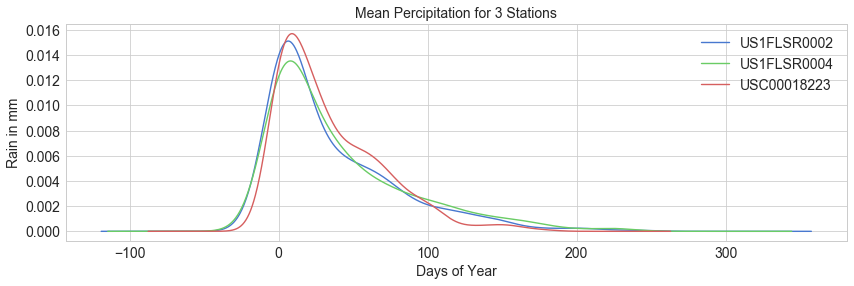

In [376]:
# tmax_station_df_subset.T.plot()

ax = tmax_station_df_subset.T.plot(kind='density',figsize=(14,4), fontsize=14)
# ax.plot(epoch_std)
ax.set_xlabel("Days of Year", fontsize=14)
ax.set_ylabel("Rain in mm", fontsize=14)
ax.set_title("Mean Percipitation for 3 Stations", fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

In [ ]:
ax = tmax_station_df_subset.T.plot(figsize=(14,4), fontsize=14)
# ax.plot(epoch_std)
ax.set_xlabel("Days of Year", fontsize=14)
ax.set_ylabel("Rain in mm", fontsize=14)
ax.set_title("Mean Percipitation for 3 Stations", fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

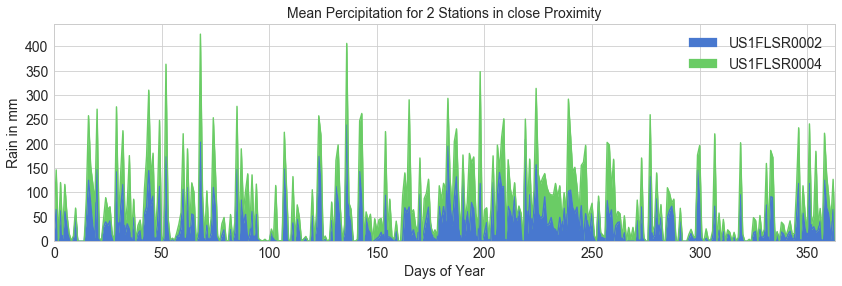

In [373]:
ax = tmax_station_df_subset.iloc[0:2].T.plot(kind='area',figsize=(14,4), fontsize=14)
ax.set_xlabel("Days of Year", fontsize=14)
ax.set_ylabel("Rain in mm", fontsize=14)
ax.set_title("Mean Percipitation for 2 Stations in close Proximity", fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

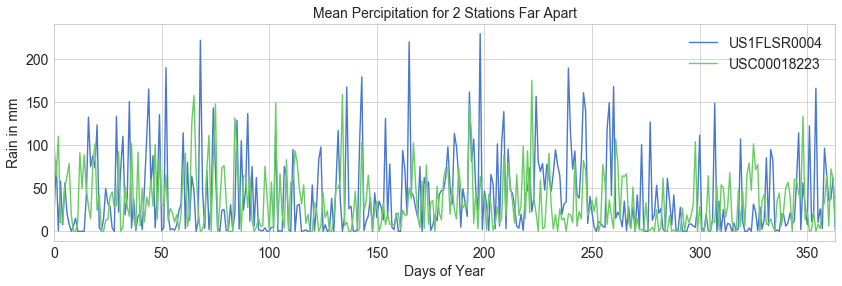

In [346]:
ax = tmax_station_df_subset.iloc[1:3].T.plot(figsize=(14,4), fontsize=14)
ax.set_xlabel("Days of Year", fontsize=14)
ax.set_ylabel("Rain in mm", fontsize=14)
ax.set_title("Mean Percipitation for 2 Stations Far Apart", fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

In [352]:
tmax_station_df_subset

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
station,,,,,,,,,,,,,,,,,,,,,
US1FLSR0002,15.200,65.000,0.6,62.0,6.0,60.600,32.6,7.80,1.000,4.6,...,18.4,22.8,41.200,1.600,125.000,69.40,54.600,4.6,65.00,1.00
US1FLSR0004,18.800,81.400,0.6,58.4,7.6,56.000,21.4,8.20,0.000,6.2,...,166.2,10.2,26.000,3.200,96.600,66.20,35.600,37.6,62.00,1.00
USC00018223,102.625,63.875,110.5,10.5,10.5,51.125,63.5,78.75,19.375,0.0,...,0.0,8.0,3.125,28.625,33.125,64.75,6.375,72.5,60.25,9.25


In [365]:
tmax_station_df_subset.iloc[1:3]

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
station,,,,,,,,,,,,,,,,,,,,,
US1FLSR0004,18.800,81.400,0.6,58.4,7.6,56.000,21.4,8.20,0.000,6.2,...,166.2,10.2,26.000,3.200,96.600,66.20,35.600,37.6,62.00,1.00
USC00018223,102.625,63.875,110.5,10.5,10.5,51.125,63.5,78.75,19.375,0.0,...,0.0,8.0,3.125,28.625,33.125,64.75,6.375,72.5,60.25,9.25


In [361]:
import scipy.stats as stats
stats.kruskal(tmax_station_df_subset.iloc[0],tmax_station_df_subset.iloc[1])#,tmax_station_df_subset.iloc[2])

KruskalResult(statistic=1.4696584194115518, pvalue=0.22539959515258889)

In [363]:
stats.kruskal(tmax_station_df_subset.iloc[1],tmax_station_df_subset.iloc[2])#,tmax_station_df_subset.iloc[2])

KruskalResult(statistic=1.1206440692479795e-06, pvalue=0.99915535575194547)

In [353]:
stats.f_oneway(tmax_station_df_subset.iloc[0],tmax_station_df_subset.iloc[1])

F_onewayResult(statistic=1.4359230383981525, pvalue=0.23119124780827763)

In [359]:
stats.mannwhitneyu(tmax_station_df_subset.iloc[0],tmax_station_df_subset.iloc[2])

MannwhitneyuResult(statistic=62549.0, pvalue=0.095826128877260164)

In [366]:
stats.mannwhitneyu(tmax_station_df_subset.iloc[1],tmax_station_df_subset.iloc[0])

MannwhitneyuResult(statistic=62813.5, pvalue=0.11273356818902058)

In [357]:
ttest = stats.ttest_ind(tmax_station_df_subset.iloc[0],tmax_station_df_subset.iloc[2])

# ttest=stats.ttest_ind(old,new)
print 't-test independent', ttest

t-test independent Ttest_indResult(statistic=0.54842634705145643, pvalue=0.58356778822314359)


## Unpacking vector year data into seperate numpy arrays

In [379]:
# Unpack all the year vector data as numpy array and store it in a dict called year_data
# all data in 10ths of a degree C - https://earthscience.stackexchange.com/questions/5015/what-is-celsius-degrees-to-tenths
year_data = {}
for m in STAT.keys():
    tmp_spark_df = spark_df.filter(spark_df.measurement == m)
    rows = tmp_spark_df.rdd.map(lambda row: unpackArray(row['vector'],np.float16)).collect()
    year_data[m] = np.vstack(rows)

print year_data.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [380]:
total = 0
for k in year_data.keys():
    rows_of_data = len(year_data[k])
    print 'rows of data for - {} - {}'.format(k, rows_of_data)
    total += rows_of_data
print total

rows of data for - TMIN - 2021
rows of data for - TOBS - 1344
rows of data for - TMAX - 2020
rows of data for - SNOW - 2107
rows of data for - SNWD - 1973
rows of data for - PRCP - 2784
12249


In [381]:
#create df and convert all 10ths of C to F
df_tmin = pd.DataFrame(year_data['TMIN']).applymap(lambda x: convert_C_to_F(x))
print df_tmin.shape
df_tmin.head()

(2021, 365)


,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,38.1,43.7,33.1,29.2,27.0,28.1,34.8,40.3,34.2,29.8,...,39.2,35.9,32.6,31.4,29.8,35.9,34.8,38.1,36.4,43.1
1,45.3,49.2,48.7,40.9,34.8,34.8,39.8,39.2,47.0,42.6,...,31.4,29.8,32.6,35.3,35.3,37.6,38.7,34.2,30.3,28.1
2,29.8,28.7,29.2,31.4,29.8,34.8,33.1,37.0,33.7,29.2,...,36.4,44.2,37.6,35.3,33.1,30.3,33.7,37.6,35.9,34.2
3,34.2,34.2,32.6,29.8,29.8,38.7,34.8,32.0,32.0,39.2,...,40.9,44.2,45.3,36.4,34.2,33.1,32.0,34.2,38.1,47.0
4,44.2,40.3,34.2,32.6,33.1,37.0,32.6,37.6,38.7,39.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Univariate Analysis

In [383]:
#create dfs for the temp data and convert C --> F
df_tmin = pd.DataFrame(year_data['TMIN']).applymap(lambda x: convert_C_to_F(x))
df_tmax = pd.DataFrame(year_data['TMAX']).applymap(lambda x: convert_C_to_F(x))
df_tobs = pd.DataFrame(year_data['TOBS']).applymap(lambda x: convert_C_to_F(x))

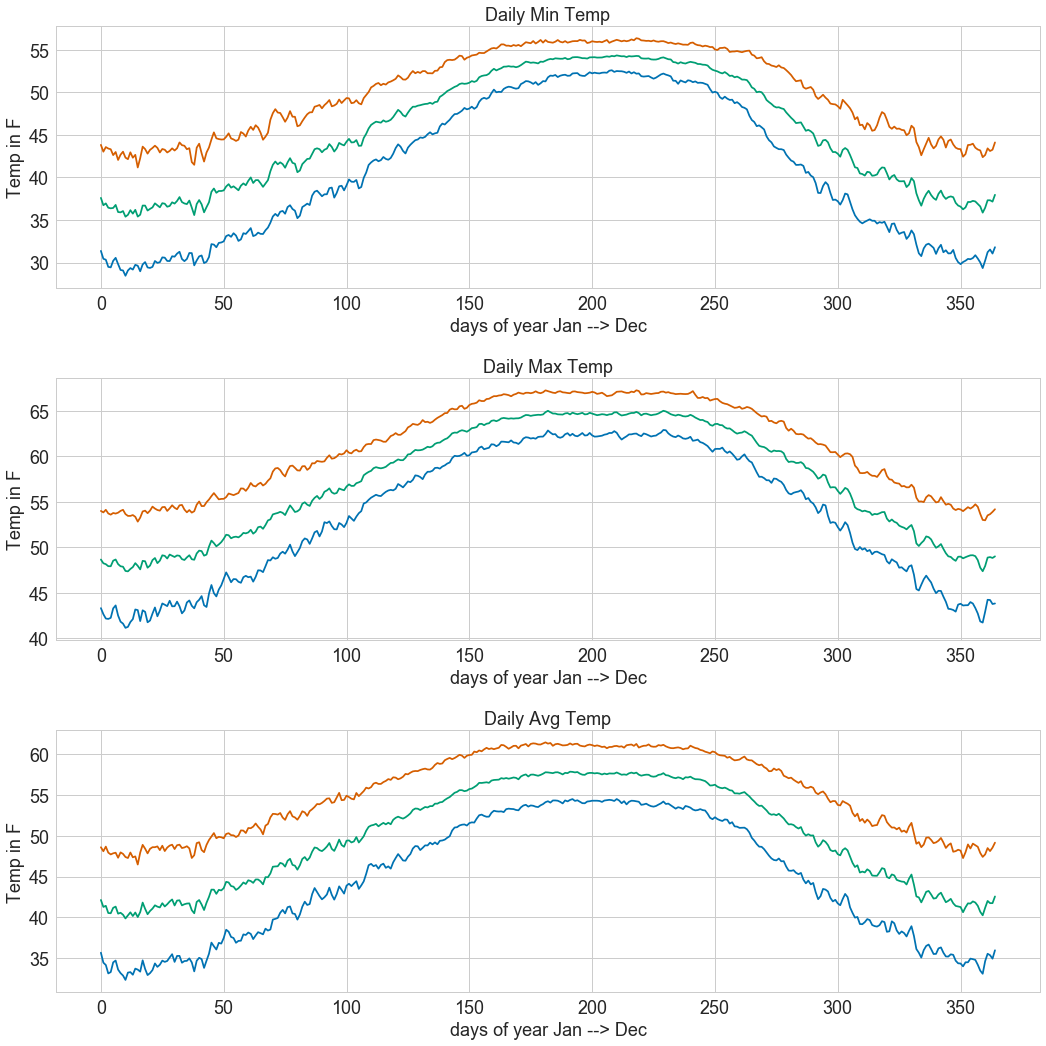

In [127]:
# plot all of the yearly TEMP data
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(mean_std(df_tmin))
plt.title('Daily Min Temp', fontsize=18)
plt.ylabel('Temp in F', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.subplot(3,1,2)
plt.plot(mean_std(df_tmax))
plt.title('Daily Max Temp', fontsize=18)
plt.ylabel('Temp in F', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.subplot(3,1,3)
plt.plot(mean_std(df_tobs))
plt.title('Daily Avg Temp', fontsize=18)
plt.ylabel('Temp in F', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

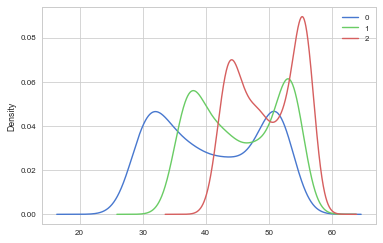

In [385]:
pd.DataFrame(mean_std(df_tmin)).plot(kind='kde')

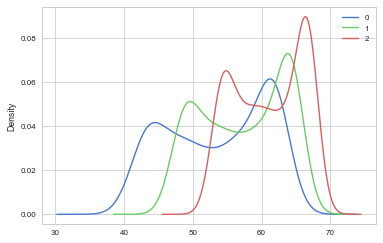

In [386]:
pd.DataFrame(mean_std(df_tmax)).plot(kind='kde')

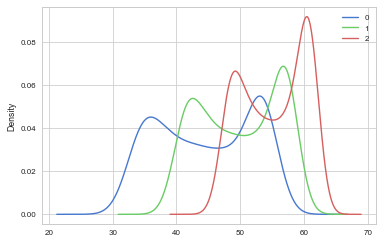

In [387]:
pd.DataFrame(mean_std(df_tobs)).plot(kind='kde')

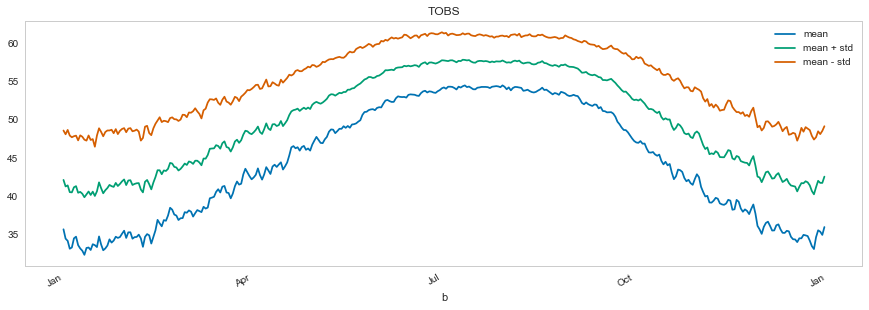

In [177]:
fig, ax = plt.subplots(figsize=(15,5));
YP=YearPlotter()
YP.plot(mean_std(df_tobs),fig,ax, labels=['mean','mean + std','mean - std'], title='TOBS', ax_labs=['a','b'])

In [178]:
# make dfs for snow
df_snow = pd.DataFrame(year_data['SNOW'])
df_snwd = pd.DataFrame(year_data['SNWD'])

In [179]:
pct_zero_col = (df_snow[df_snow == 0].count(axis=0)/len(df_snow.index)).mean()
print 'Percentage of Zeroes in the Snow (SNOW) Data = {}%'.format(round(100*pct_zero_col,2))
pct_zero_col = (df_snwd[df_snwd == 0].count(axis=0)/len(df_snwd.index)).mean()
print 'Percentage of Zeroes in the Snow (SNWD) Data = {}%'.format(round(100*pct_zero_col,2))


Percentage of Zeroes in the Snow (SNOW) Data = 99.08%
Percentage of Zeroes in the Snow (SNWD) Data = 99.05%


In [181]:
df_snow.shape

(2107, 365)

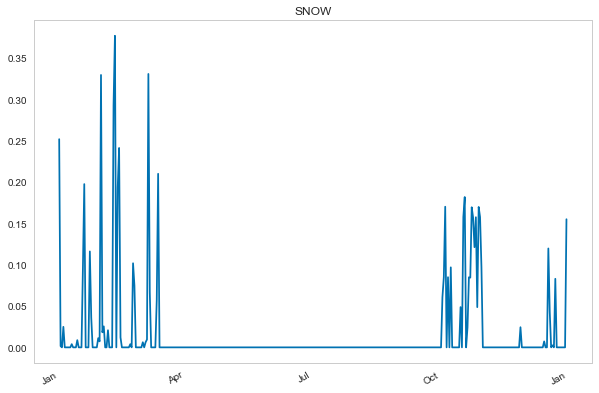

In [163]:
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(df_snow.mean(),fig,ax,title='SNOW')

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(2,1,1)
plt.plot(df_snow.mean())
plt.title('Daily Avg Snow', fontsize=18)
plt.ylabel('Snowfall in mm', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.subplot(2,1,2)
plt.plot(df_snwd.mean())
plt.title('Daily Avg Snow Depth', fontsize=18)
plt.ylabel('Snow Depth in mm', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [128]:
#create dfs for the percipitation data and leave units in mm
df_prcp = pd.DataFrame(year_data['PRCP'])


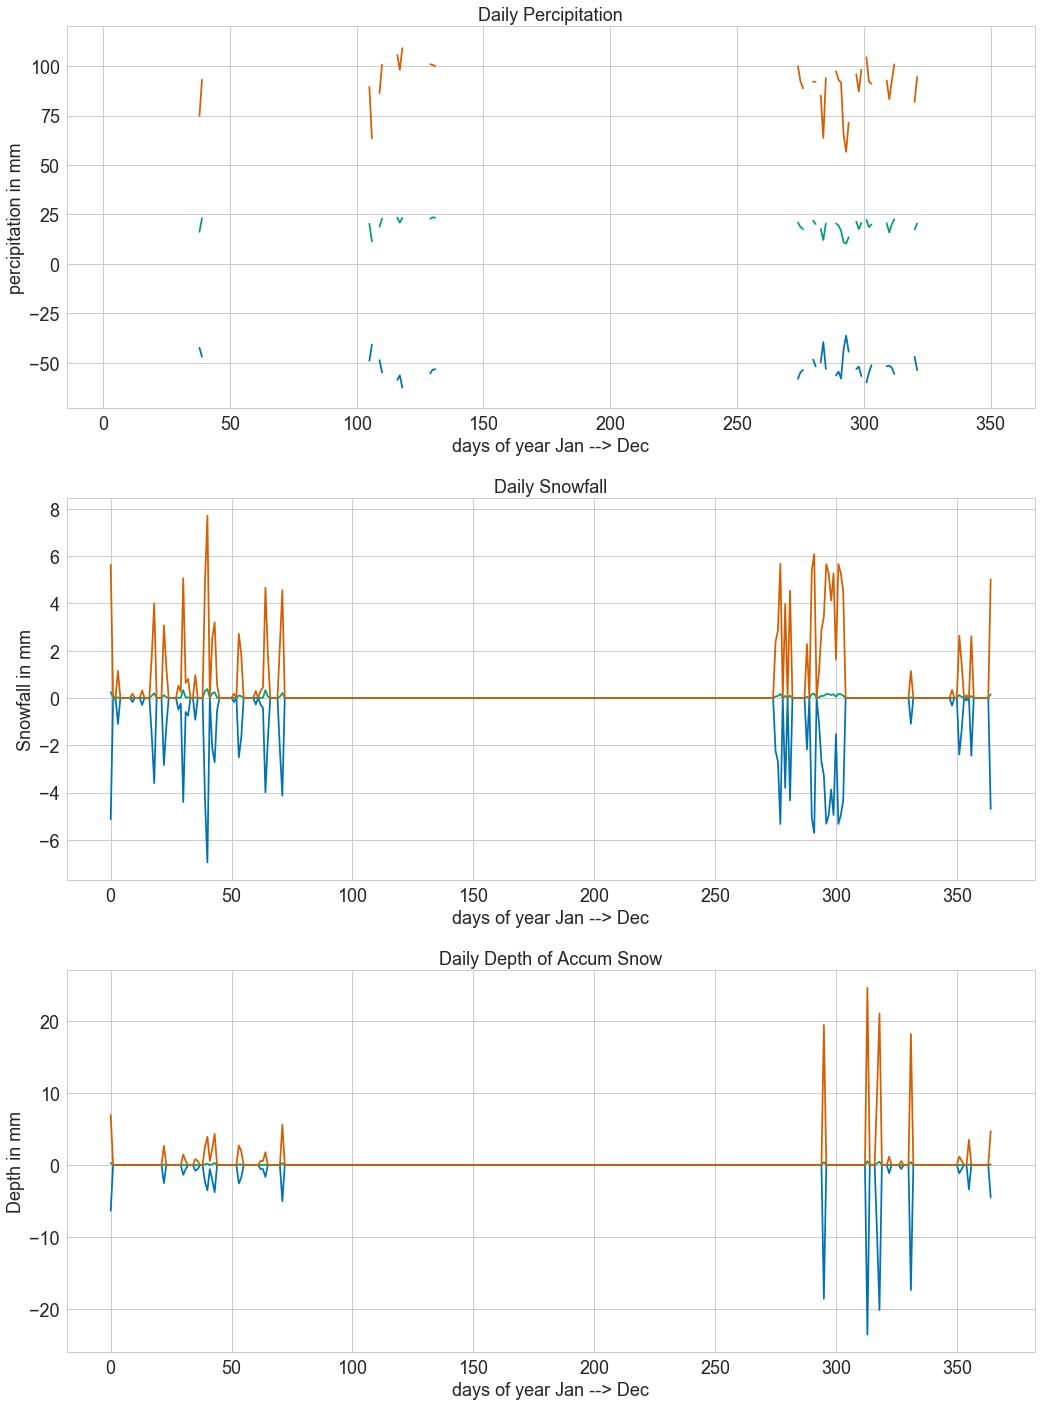

In [132]:
# plot all of the yearly percipitation/snow 
plt.figure(figsize=(15,20))

plt.subplot(3,1,1)
plt.plot(mean_std(df_prcp))
plt.title('Daily Percipitation', fontsize=18)
plt.ylabel('percipitation in mm', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.subplot(3,1,2)
plt.plot(mean_std(df_snow))
plt.title('Daily Snowfall', fontsize=18)
plt.ylabel('Snowfall in mm', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.subplot(3,1,3)
plt.plot(mean_std(df_snwd))
plt.title('Daily Depth of Accum Snow', fontsize=18)
plt.ylabel('Depth in mm', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)

plt.tight_layout()
plt.show()

In [134]:
df_prcp.head(10)

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,0.0,0.0,246.0,3.0,NaN,102.0,NaN,0.0,0.0,157.0,...,0.0,NaN,442.0,0.0,0.0,8.0,0.0,0.0,76.0,81.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,173.0,0.0,0.0,20.0,10.0,0.0,0.0
2,0.0,0.0,0.0,61.0,0.0,NaN,221.0,0.0,0.0,0.0,...,NaN,0.0,0.0,264.0,0.0,NaN,0.0,0.0,0.0,213.0
3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,91.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,0.0,0.0,0.0,0.0,188.0
4,36.0,135.0,0.0,0.0,28.0,239.0,0.0,0.0,0.0,30.0,...,23.0,160.0,0.0,0.0,114.0,48.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,333.0,3.0,348.0,8.0,0.0,0.0,...,0.0,25.0,0.0,36.0,0.0,0.0,495.0,259.0,328.0,0.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,23.0,20.0,0.0,0.0,208.0,0.0,NaN,NaN
7,3.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,25.0
8,3.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,0.0,10.0,...,0.0,0.0,244.0,439.0,0.0,0.0,119.0,3.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,0.0,0.0,43.0,0.0,0.0,13.0,8.0,0.0,0.0


In [148]:
df_prcp.shape[0]*df_prcp.shape[1]/float(df_prcp.isnull().sum().sum())

44.14823825867837

In [140]:
pct_zero_col = (df_prcp[df_prcp == 0].count(axis=0)/len(df_prcp.index)).mean()
print 'Percentage of Zeroes in the Percipitation Data = {}%'.format(round(100*pct_zero_col,2))

# pct_nan_col = (df_prcp[df_prcp == NaN].count(axis=0)/len(df_prcp.index)).mean()
# print 'Percentage of Zeroes in the Percipitation Data = {}%'.format(pct_nan_col)
df_prcp.isnull().sum().sum()

Percentage of Zeroes in the Percipitation Data = 70.18%


23017

## PCA Analysis for Percepitation

In [193]:
df_pca = df.copy()

In [194]:
tmp_df = df_pca[df_pca['measurement'] == 'PRCP']
tmp_df['station'].value_counts().index[0]

u'USC00082220'

In [195]:
#creatng meta df for station from above valuecounts()
USC00082220_prcp_meta_df = tmp_df[tmp_df['station'] == 'USC00082220']
print USC00082220_prcp_meta_df.shape
USC00082220_prcp_meta_df.head(10)

(97, 8)


,elevation,latitude,longitude,measurement,station,undefs,vector,year
7045,74.7,30.7244,-86.0939,PRCP,USC00082220,4,"[0, 0, 0, 0, 96, 86, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1897.0
7046,74.7,30.7244,-86.0939,PRCP,USC00082220,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 192...",1898.0
7047,74.7,30.7244,-86.0939,PRCP,USC00082220,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 126, 0, 0, 1...",1899.0
7048,74.7,30.7244,-86.0939,PRCP,USC00082220,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1900.0
7049,74.7,30.7244,-86.0939,PRCP,USC00082220,3,"[120, 95, 64, 85, 192, 84, 0, 0, 0, 0, 0, 0, 0...",1901.0
7050,74.7,30.7244,-86.0939,PRCP,USC00082220,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1902.0
7051,74.7,30.7244,-86.0939,PRCP,USC00082220,19,"[0, 0, 72, 88, 0, 0, 240, 87, 144, 85, 0, 0, 0...",1903.0
7052,74.7,30.7244,-86.0939,PRCP,USC00082220,1,"[0, 0, 176, 85, 0, 73, 0, 0, 0, 0, 0, 0, 168, ...",1904.0
7053,74.7,30.7244,-86.0939,PRCP,USC00082220,45,"[0, 0, 192, 81, 0, 0, 0, 0, 0, 0, 20, 93, 0, 0...",1905.0
7054,74.7,30.7244,-86.0939,PRCP,USC00082220,23,"[0, 126, 0, 126, 48, 95, 0, 126, 0, 126, 0, 12...",1906.0


In [196]:
#query sql context rdd for prcp for station from above valuecounts() to unpack year vectors
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00082220')
print Query
tmp_df = sqlContext.sql(Query)
print tmp_df.count(),'rows'
tmp_df.show(2)
rows=tmp_df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
USC00082220_prcp=np.vstack(rows)
USC00082220_prcp=USC00082220_prcp  
shape(USC00082220_prcp)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00082220'
97 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     74.7| 30.7244| -86.0939|       PRCP|USC00082220|     4|[00 00 00 00 60 5...|1897.0|BSSSBSBS|
|     74.7| 30.7244| -86.0939|       PRCP|USC00082220|     0|[00 00 00 00 00 0...|1898.0|BSSSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(97, 365)

In [197]:
#creating year vector dataframe for weather station from above for PCA analysis.
USC00082220_prcp_df = pd.DataFrame(USC00082220_prcp)
USC00082220_prcp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,229.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,102.0,...,102.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,173.0
2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,13.0,0.0,216.0,...,0.0,0.0,254.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,10.0,0.0,0.0,0.0,343.0,38.0,216.0,648.0,0.0
4,478.0,84.0,76.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,...,0.0,76.0,0.0,0.0,89.0,0.0,117.0,102.0,0.0,0.0


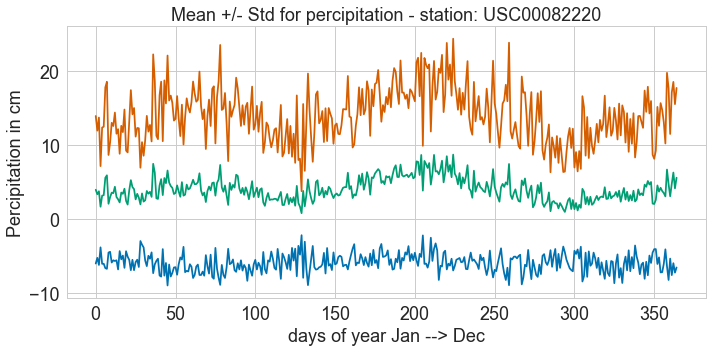

In [218]:
# plot all of the yearly TEMP data
plt.figure(figsize=(10,5))

plt.subplot(1,1,1)
plt.plot(mean_std_nparray(USC00082220_prcp/10)) #convert to cm
plt.title('Mean +/- Std for percipitation - station: USC00082220', fontsize=18)
plt.ylabel('Percipitation in cm', fontsize=18)
plt.xlabel('days of year Jan --> Dec', fontsize=18)
plt.tick_params(labelsize=18)


plt.tight_layout()
plt.show()

In [225]:
USC00082220_prcp_df

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,229.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.0,0.0,102.0,...,102.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,173.0
2,0.0,0.0,0.0,0.0,0.0,NaN,0.0,13.0,0.0,216.0,...,0.0,0.0,254.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,10.0,0.0,0.0,0.0,343.0,38.0,216.0,648.0,0.0
4,478.0,84.0,76.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,...,0.0,76.0,0.0,0.0,89.0,0.0,117.0,102.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,13.0
6,0.0,137.0,0.0,127.0,89.0,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,91.0,10.0,0.0,0.0,0.0,213.0,0.0,0.0,371.0,...,0.0,0.0,43.0,13.0,0.0,274.0,0.0,0.0,0.0,0.0
8,0.0,46.0,0.0,0.0,0.0,325.0,0.0,0.0,0.0,0.0,...,0.0,0.0,203.0,0.0,0.0,0.0,0.0,203.0,0.0,0.0
9,NaN,NaN,460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,135.0,381.0,0.0


## epoched temp analysis

In [295]:
import array
import struct


tmin = []
df_tmin = df.copy()

In [296]:
df_tmin = df_tmin[['vector', 'year']]
df_tmin.head()

,vector,year
0,"[0, 0, 0, 0, 176, 91, 0, 66, 0, 126, 96, 86, 0...",2009.0
1,"[64, 90, 240, 90, 128, 88, 128, 81, 224, 80, 8...",1999.0
2,"[32, 91, 120, 91, 72, 91, 152, 90, 0, 88, 184,...",2000.0
3,"[144, 85, 224, 84, 160, 83, 160, 86, 8, 89, 12...",2001.0
4,"[224, 84, 48, 84, 48, 84, 224, 85, 128, 88, 96...",2002.0


In [306]:
for index, row in df_tmin.iterrows():
    tmp_year = []
    tmp_year.append(row[1])
    for n in row[0]:
        tmp_year.append(n)
#         print tmp_year
    tmin.append(tmp_year)
    break
len(tmin)
    

12252

In [303]:
tmin[0]


[2009.0,
 0,
 0,
 0,
 0,
 176,
 91,
 0,
 66,
 0,
 126,
 96,
 86,
 0,
 126,
 0,
 0,
 0,
 0,
 232,
 88,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 0,
 32,
 87,
 0,
 0,
 0,
 126,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 96,
 86,
 64,
 78,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 32,
 80,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 96,
 82,
 0,
 0,
 196,
 92,
 248,
 89,
 0,
 126,
 128,
 74,
 0,
 0,
 240,
 87,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 126,
 0,
 0,
 0,
 0,
 0,
 0,
 192,
 77,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 0,
 160,
 82,
 192,
 84,
 192,
 88,
 0,
 126,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 126,
 192,
 94,
 96,
 86,
 0,
 126,
 0,
 0,
 40,
 93,
 0,
 87,
 36,
 95,
 0,
 0,
 0,
 0,
 0,
 72,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 126,

In [ ]:
year_data_2 = {}
for m in []:
# for m in STAT.keys():
    tmp_spark_df = spark_df.filter(spark_df.measurement == 'TMIN')
    rows = tmp_spark_df.rdd.map(lambda row: unpackArray(row['vector'],np.float16)).collect()
    print rows
    break
    year_data['TMIN'] = np.vstack(rowsrow['year'])

print year_data_2.keys()

In [17]:
# Unpack all the year vector data as numpy array and store it in a dict called year_data
# all data in 10ths of a degree C - https://earthscience.stackexchange.com/questions/5015/what-is-celsius-degrees-to-tenths
year_data_2 = {}
for m in STAT.keys():
    tmp_spark_df = spark_df.filter(spark_df.measurement == m)
    rows = tmp_spark_df.rdd.map(lambda row: np.append(unpackArray(row['vector'],np.float16),row['year'])).collect()
    year_data_2[m] = np.vstack(rows)

print year_data_2.keys()

['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [48]:
tmin_df = pd.DataFrame.from_dict(year_data_2['TMIN'])
tmin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,61.0,117.0,11.0,-28.0,-50.0,-39.0,28.0,83.0,22.0,-22.0,...,39.0,6.0,-6.0,-22.0,39.0,28.0,61.0,44.0,111.0,1999.0
1,133.0,172.0,167.0,89.0,28.0,28.0,78.0,72.0,150.0,106.0,...,-22.0,6.0,33.0,33.0,56.0,67.0,22.0,-17.0,-39.0,2000.0
2,-22.0,-33.0,-28.0,-6.0,-22.0,28.0,11.0,50.0,17.0,-28.0,...,122.0,56.0,33.0,11.0,-17.0,17.0,56.0,39.0,22.0,2001.0
3,22.0,22.0,6.0,-22.0,-22.0,67.0,28.0,0.0,0.0,72.0,...,122.0,133.0,44.0,22.0,11.0,0.0,22.0,61.0,150.0,2002.0
4,122.0,83.0,22.0,6.0,11.0,50.0,6.0,56.0,67.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003.0


In [49]:
tmin_df.iloc[:,365] = tmin_df.iloc[:,365].astype(str).apply(lambda x: x.split('.')[0])
# tmin_df.iloc[:,365] = pd.to_datetime(tmin_df.iloc[:,365], format='%Y')
tmin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,365
0,61.0,117.0,11.0,-28.0,-50.0,-39.0,28.0,83.0,22.0,-22.0,...,39.0,6.0,-6.0,-22.0,39.0,28.0,61.0,44.0,111.0,1999
1,133.0,172.0,167.0,89.0,28.0,28.0,78.0,72.0,150.0,106.0,...,-22.0,6.0,33.0,33.0,56.0,67.0,22.0,-17.0,-39.0,2000
2,-22.0,-33.0,-28.0,-6.0,-22.0,28.0,11.0,50.0,17.0,-28.0,...,122.0,56.0,33.0,11.0,-17.0,17.0,56.0,39.0,22.0,2001
3,22.0,22.0,6.0,-22.0,-22.0,67.0,28.0,0.0,0.0,72.0,...,122.0,133.0,44.0,22.0,11.0,0.0,22.0,61.0,150.0,2002
4,122.0,83.0,22.0,6.0,11.0,50.0,6.0,56.0,67.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003


In [51]:
tmin_df.rename(columns = {365:'year'}, inplace=True)
tmin_df.head()

In [52]:
tmin_df.head()

,0,1,2,3,4,5,6,7,8,9,...,356,357,358,359,360,361,362,363,364,year
0,61.0,117.0,11.0,-28.0,-50.0,-39.0,28.0,83.0,22.0,-22.0,...,39.0,6.0,-6.0,-22.0,39.0,28.0,61.0,44.0,111.0,1999
1,133.0,172.0,167.0,89.0,28.0,28.0,78.0,72.0,150.0,106.0,...,-22.0,6.0,33.0,33.0,56.0,67.0,22.0,-17.0,-39.0,2000
2,-22.0,-33.0,-28.0,-6.0,-22.0,28.0,11.0,50.0,17.0,-28.0,...,122.0,56.0,33.0,11.0,-17.0,17.0,56.0,39.0,22.0,2001
3,22.0,22.0,6.0,-22.0,-22.0,67.0,28.0,0.0,0.0,72.0,...,122.0,133.0,44.0,22.0,11.0,0.0,22.0,61.0,150.0,2002
4,122.0,83.0,22.0,6.0,11.0,50.0,6.0,56.0,67.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003


In [94]:
new = tmin_df.groupby(['year']).mean().applymap(lambda x: convert_C_to_F(x)).ix['2012']

In [100]:
old = tmin_df.groupby(['year']).mean().applymap(lambda x: convert_C_to_F(x)).ix['1892']

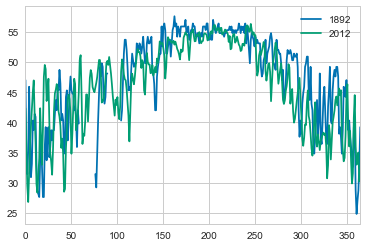

In [115]:
t_df = pd.concat([old,new], axis=1)#.plot()
t_df.plot()

In [113]:
from __future__ import division
from scipy import stats

ttest = stats.ttest_ind(old.dropna(), new.dropna())

# ttest=stats.ttest_ind(old,new)
print 't-test independent', ttest

t-test independent Ttest_indResult(statistic=2.4501102478116636, pvalue=0.014526108030847289)


In [114]:
print old.mean(), new.mean()

47.519760479 46.1523561644


In [ ]:
try cumsum for years to show upwards trend?, also 
look at stack overflow on right for folding of rows...

In [126]:
tmin_df_mean = tmin_df.groupby(['year']).median().applymap(lambda x: convert_C_to_F(x))

In [131]:
tmin_df_mean.shape

(123, 365)

In [129]:
tmin_df_mean.head(10)

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
year,,,,,,,,,,,,,,,,,,,,,
1890,43.10,49.20,46.40,46.40,46.40,47.00,50.90,49.20,40.30,45.30,...,41.40,42.00,42.6,44.80,35.9,34.20,31.40,32.60,41.40,43.10
1891,46.40,35.30,30.30,30.90,33.70,35.90,35.90,38.70,40.30,38.70,...,45.30,44.80,44.8,43.70,39.8,32.00,34.20,43.70,37.00,38.70
1892,47.00,33.70,31.40,35.30,45.90,37.60,30.90,33.10,40.30,38.70,...,34.20,32.60,39.2,40.30,28.7,24.80,27.00,28.70,33.10,39.20
1893,36.70,35.35,36.70,37.00,36.75,31.70,33.40,30.65,30.90,32.85,...,37.60,45.90,44.8,45.90,45.9,37.60,42.00,48.70,46.40,36.40
1894,31.70,32.80,40.05,45.90,50.30,50.05,45.60,45.90,45.35,44.50,...,41.15,39.75,42.0,45.90,34.5,29.75,24.75,25.05,31.75,29.75
1895,31.45,36.70,34.20,34.50,40.90,45.85,47.25,35.60,31.40,31.15,...,40.60,43.40,40.9,48.70,37.8,35.90,36.40,37.80,31.15,30.05
1896,29.20,30.90,39.20,26.75,26.20,30.05,37.30,41.45,37.00,35.05,...,31.45,36.15,34.2,28.95,29.2,31.75,34.75,36.75,38.95,42.55
1897,44.80,46.40,40.90,34.80,30.90,28.10,27.60,28.10,30.90,32.60,...,39.20,34.20,37.0,36.40,35.3,35.90,32.00,32.00,35.30,39.20
1898,30.05,24.50,27.00,33.95,37.80,37.30,39.20,42.00,46.45,47.55,...,46.45,38.65,35.9,36.15,30.3,27.60,33.70,37.30,43.95,36.70


In [192]:
tmin_epoch = []
start,end = 0, 16
while end < tmin_df_mean.shape[0]:
    tmin_epoch.append(tmin_df_mean.ix[start:end].median())
    start += 15
    end += 15

In [193]:
tmin_epoch_df = pd.DataFrame(tmin_epoch)

In [194]:
tmin_epoch_df

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,32.300,35.325,36.000,34.65,34.775,36.450,34.350,34.350,37.700,38.700,...,38.150,38.925,38.25,42.000,34.350,33.100,33.950,36.575,34.900,36.550
1,36.425,40.200,35.875,34.65,36.850,38.675,33.375,33.400,33.825,36.175,...,36.750,36.150,36.00,35.900,32.700,33.525,35.450,36.125,37.600,37.450
2,37.025,33.125,38.375,39.50,40.900,40.200,40.175,41.275,40.725,35.600,...,37.550,35.725,36.70,36.025,34.775,37.575,38.525,38.550,35.850,38.375
3,40.600,37.975,38.700,37.55,34.775,37.550,37.975,37.300,38.800,37.150,...,36.750,38.650,38.40,38.250,40.875,38.525,40.725,39.100,35.050,37.150
4,35.900,37.000,37.850,36.75,38.700,38.950,36.700,34.650,35.050,35.600,...,35.600,37.600,38.10,38.700,39.100,38.550,39.500,38.150,37.850,37.850
5,39.250,37.000,38.250,35.35,33.825,34.500,35.600,34.500,36.400,35.600,...,35.475,34.925,36.70,36.450,33.400,33.525,34.500,37.000,39.500,39.800
6,38.700,37.125,37.600,35.90,32.700,32.300,35.200,35.050,35.850,37.000,...,39.200,38.950,38.10,33.550,33.400,35.600,38.100,36.200,36.425,36.700
7,37.125,37.300,35.200,35.05,32.400,34.500,33.100,34.800,35.900,33.700,...,34.375,36.700,34.65,33.825,32.300,32.725,32.300,33.950,34.900,37.850


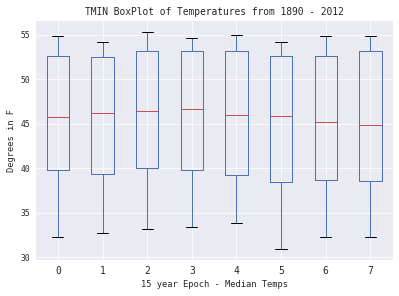

In [195]:
ax = tmin_epoch_df.T.boxplot()
ax.set_xlabel("15 year Epoch - Median Temps")
ax.set_ylabel("Degrees in F")
ax.set_title("TMIN BoxPlot of Temperatures from 1890 - 2012")
# ax = tmin_epoch_df.T.plot(type=boxplot,title='box')

In [196]:

tmax_df = pd.DataFrame.from_dict(year_data_2['TMAX'])
tmax_df.iloc[:,365] = tmax_df.iloc[:,365].astype(str).apply(lambda x: x.split('.')[0])
tmax_df.rename(columns = {365:'year'}, inplace=True)
tmax_df_mean = tmax_df.groupby(['year']).median().applymap(lambda x: convert_C_to_F(x))

tmax_epoch = []
start,end = 0, 16
while end < tmax_df_mean.shape[0]:
    tmax_epoch.append(tmax_df_mean.ix[start:end].median())
    start += 15
    end += 15
    
    
tmax_epoch_df = pd.DataFrame(tmax_epoch)
tmax_epoch_df

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,46.875,48.225,47.600,47.850,48.40,48.675,50.200,49.500,48.150,50.050,...,48.550,50.30,49.350,48.400,48.225,46.275,46.750,48.700,48.800,49.750
1,51.400,49.500,50.625,50.350,50.35,49.200,47.950,49.625,48.275,48.950,...,50.175,47.60,49.925,49.500,48.125,47.550,47.725,50.200,48.950,49.925
2,48.700,48.150,49.750,49.925,50.35,51.000,51.150,51.450,50.475,50.075,...,49.225,51.00,51.850,50.175,48.675,50.300,51.150,50.575,51.025,50.600
3,52.850,51.150,50.475,50.325,49.20,51.150,49.075,50.050,46.750,48.400,...,50.900,51.45,51.700,52.300,52.300,49.800,50.750,48.700,49.500,50.600
4,47.600,50.450,51.025,48.525,50.05,49.250,48.700,48.100,49.375,50.175,...,50.175,50.85,48.400,47.300,48.100,49.500,49.200,49.200,49.800,48.000
5,49.250,47.125,49.500,48.550,46.70,48.700,49.800,49.350,46.150,45.600,...,47.850,47.85,49.500,48.700,47.000,47.600,50.050,49.375,49.350,49.525
6,49.200,47.850,46.400,45.200,45.45,48.550,49.800,49.500,46.450,47.850,...,49.350,51.70,50.600,45.050,45.900,49.250,51.700,49.650,47.850,48.700
7,50.050,50.300,48.950,49.625,49.25,50.050,48.125,48.825,49.750,47.425,...,50.450,50.35,49.375,47.850,43.675,46.300,46.400,49.250,51.275,50.900


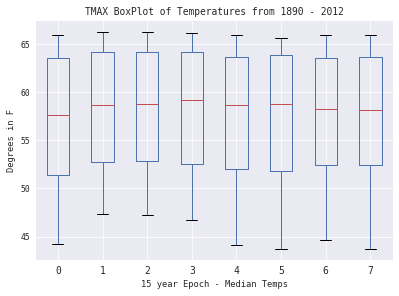

In [197]:
ax = tmax_epoch_df.T.boxplot()
ax.set_xlabel("15 year Epoch - Median Temps")
ax.set_ylabel("Degrees in F")
ax.set_title("TMAX BoxPlot of Temperatures from 1890 - 2012")

In [210]:
tobs_df = pd.DataFrame.from_dict(year_data_2['TOBS'])
tobs_df.iloc[:,365] = tobs_df.iloc[:,365].astype(str).apply(lambda x: x.split('.')[0])
tobs_df.rename(columns = {365:'year'}, inplace=True)
tobs_df_mean = tobs_df.groupby(['year']).median().applymap(lambda x: convert_C_to_F(x))

tobs_epoch = []
start,end = 0, 16
while end < tobs_df_mean.shape[0]+1:
    tobs_epoch.append(tobs_df_mean.ix[start:end].median())
    start += 15
    end += 15
    
    
tobs_epoch_df = pd.DataFrame(tobs_epoch)
tobs_epoch_df

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,45.850,45.575,41.750,41.050,43.950,42.850,43.675,41.450,43.950,46.275,...,44.200,42.000,43.675,45.900,40.900,43.700,44.20,46.400,43.700,44.500
1,42.250,44.500,44.925,46.700,47.575,44.475,44.800,45.350,46.200,45.625,...,42.150,42.400,43.825,41.300,42.975,44.225,41.45,40.325,43.550,43.925
2,43.825,43.950,44.650,44.800,44.350,46.725,47.000,42.700,40.900,42.425,...,46.275,47.575,46.725,47.850,47.450,45.600,44.50,44.800,46.325,45.350
3,42.575,45.475,45.050,44.500,45.050,44.775,41.700,44.500,45.450,43.950,...,44.625,45.025,45.050,44.775,45.300,44.925,44.65,43.675,43.825,42.850
4,39.775,42.150,43.400,41.975,39.750,43.100,41.450,40.900,42.825,39.075,...,43.100,42.150,40.900,42.000,41.450,42.975,43.70,45.600,44.800,43.400
5,41.450,37.150,38.925,37.850,35.325,39.075,42.000,38.275,36.275,39.200,...,41.575,42.850,43.350,39.100,36.825,38.550,44.50,39.200,39.500,42.550
6,40.600,41.700,42.150,36.700,38.950,39.200,37.425,38.825,39.750,39.500,...,39.750,41.275,37.600,34.625,35.450,34.375,38.40,40.200,37.850,42.850


In [214]:
tmax_df.shape

(2020, 366)

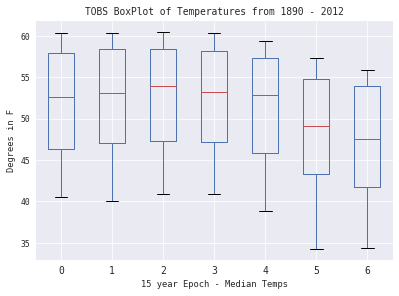

In [207]:
ax = tobs_epoch_df.T.boxplot()
ax.set_xlabel("15 year Epoch - Median Temps")
ax.set_ylabel("Degrees in F")
ax.set_title("TOBS BoxPlot of Temperatures from 1890 - 2012")

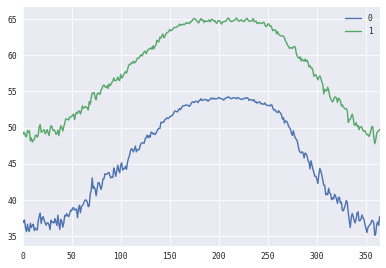

In [215]:
epoch_std = pd.concat([tmin_epoch_df.std(),tobs_epoch_df.std()],axis=1)#(tmax_epoch_df.std())
# epochs = [tmin_epoch_df.std(),tmax_epoch_df.std()]
epoch_std = pd.DataFrame(epochs)
epoch_std.T.plot()

In [237]:
epoch_std.head()

,tmin-var,tmax-var,tobs-var
0,2.516798,1.943025,2.040716
1,2.035565,1.451892,2.958266
2,1.336490,1.593566,2.224037
3,1.688194,1.718583,3.705173
4,2.986216,1.791635,4.252447


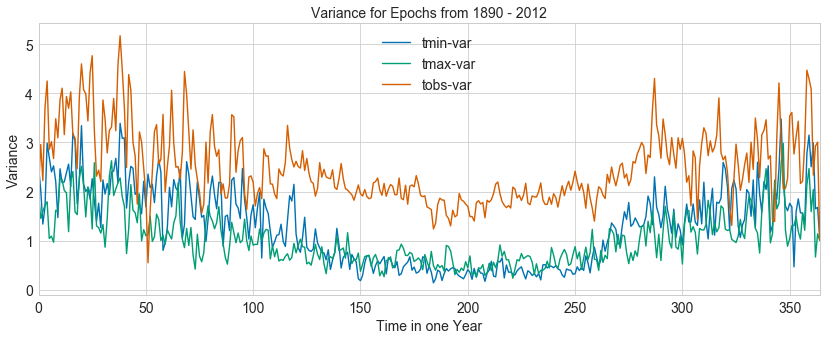

In [251]:
epochs = [tmin_epoch_df.std(),tmax_epoch_df.std(),tobs_epoch_df.std()]
epoch_std = pd.DataFrame(epochs)
epoch_std = epoch_std.T
epoch_std.columns = ['tmin-var','tmax-var','tobs-var']

# fig = plt.figure(figsize=(14,5))
# ax = fig.add_subplot(111)
ax = epoch_std.plot(figsize=(14,5), fontsize=14)
# ax.plot(epoch_std)
ax.set_xlabel("Time in one Year", fontsize=14)
ax.set_ylabel("Variance", fontsize=14)
ax.set_title("Variance for Epochs from 1890 - 2012", fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

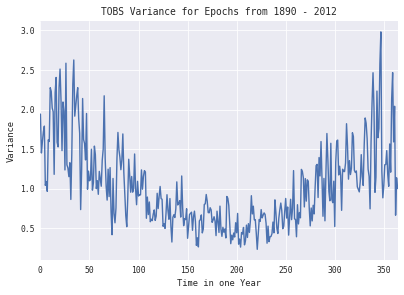

In [205]:
ax = tobs_epoch_df.std().plot()
ax.set_xlabel("Time in one Year")
ax.set_ylabel("Variance")
ax.set_title("TOBS Variance for Epochs from 1890 - 2012")

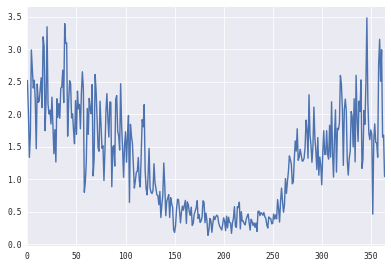

In [168]:
tmin_epoch_df.std().plot()

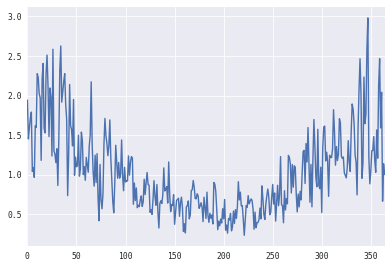

In [169]:
tmax_epoch_df.std().plot()

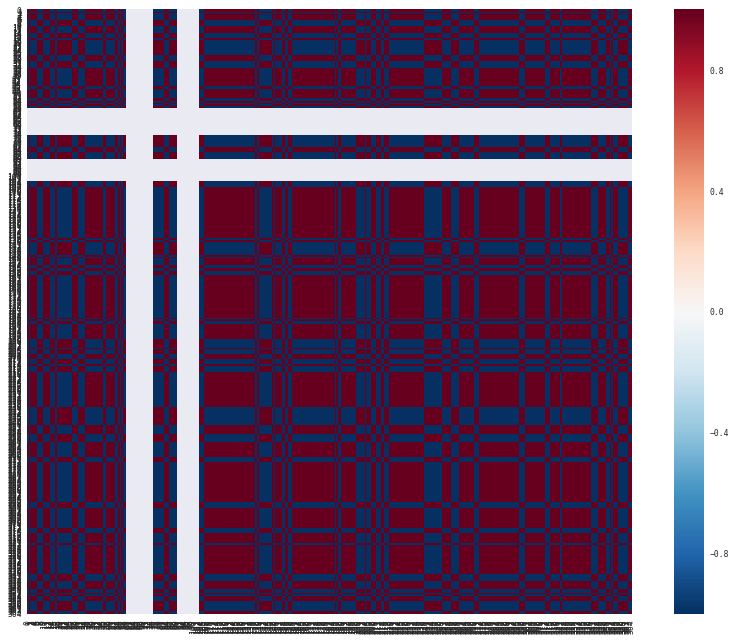

In [117]:

sns.set(context="paper", font="monospace")

# Load the datset of correlations between cortical brain networks
# df t_df #= sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)
corrmat = t_df.T.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

# Use matplotlib directly to emphasize known networks
# networks = corrmat.columns.get_level_values("network")
# for i, network in enumerate(networks):
#     if i and network != networks[i - 1]:
#         ax.axhline(len(networks) - i, c="w")
#         ax.axvline(i, c="w")
f.tight_layout()

In [70]:
tmin_df.groupby(['year']).first()

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
year,,,,,,,,,,,,,,,,,,,,,
1890,111.0,172.0,144.0,144.0,144.0,150.0,189.0,172.0,83.0,133.0,...,94.0,100.0,106.0,128.0,39.0,22.0,-6.0,6.0,94.0,111.0
1891,144.0,33.0,-17.0,-11.0,17.0,39.0,39.0,67.0,83.0,67.0,...,133.0,128.0,128.0,117.0,78.0,0.0,22.0,117.0,50.0,67.0
1892,150.0,17.0,-6.0,33.0,139.0,56.0,-11.0,11.0,83.0,67.0,...,22.0,6.0,72.0,83.0,-33.0,-72.0,-50.0,-33.0,11.0,72.0
1893,72.0,17.0,72.0,50.0,89.0,0.0,6.0,17.0,-22.0,11.0,...,56.0,139.0,128.0,139.0,139.0,56.0,100.0,167.0,144.0,44.0
1894,-6.0,-17.0,61.0,100.0,183.0,194.0,144.0,111.0,111.0,172.0,...,94.0,94.0,100.0,139.0,56.0,-17.0,-56.0,-83.0,-11.0,-6.0
1895,-28.0,50.0,44.0,17.0,50.0,144.0,161.0,61.0,-6.0,-17.0,...,72.0,100.0,106.0,178.0,72.0,28.0,44.0,83.0,11.0,-22.0
1896,0.0,22.0,72.0,-44.0,-44.0,17.0,67.0,106.0,83.0,44.0,...,17.0,61.0,61.0,-17.0,11.0,28.0,44.0,67.0,100.0,122.0
1897,161.0,178.0,122.0,22.0,0.0,-11.0,-17.0,22.0,33.0,56.0,...,72.0,33.0,50.0,56.0,33.0,44.0,28.0,33.0,56.0,100.0
1898,-11.0,-67.0,-33.0,61.0,111.0,122.0,100.0,150.0,161.0,178.0,...,156.0,72.0,67.0,50.0,0.0,11.0,39.0,94.0,156.0,17.0


In [105]:
STAT['PRCP'].keys()

['std',
 'UnDef',
 'E',
 'Cov',
 'high1000',
 'NE',
 'O',
 'low100',
 'NO',
 'high100',
 'eigvec',
 'low1000',
 'Var',
 'eigval',
 'mean',
 'SortedVals',
 'Mean']

In [106]:
STAT_Descriptions

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

In [ ]:
# root mean square analysis, substracting the mean from ach point , e.g. rain yes or 
#no 1 / 0 if mean was 0.9 subtracting mean would be 0.1 / -0.9 thus you get the residual or 
#diff

In [107]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

In [ ]:
# group by station split into sep DFs
# get df with lat long station number and count to use for a map
# univariate analysis fr each feature
#elevation analysis
# outliers
# years, stations by year analysis
# undefinned analysis for years
#count for each measurement
# start drilling down into each of the seperate measurements. 
#look at temp (assuming that there is global warming climate chnage, can I Show that the 
#     temp is unifomly increasing, according to the website it says yes, so ca n we show it, 
#     take tmax tmin, plot curves of the temp by the year, break data set into 20 year epochs, 
#     1920,1940 etc plot the mean temp throughout the year, do these curves overlap, i havea curve, 
#     gets warmer in the summer, if take 1886 - 1996 as my baseline curve, if it is the same curve
#     I should get the 0 I should get +/- if there is a trend, get the rsidual for the, COMPARE TO A GUASSIAN and do a T test to see if there is a legit 

In [ ]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

In [ ]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

In [ ]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

In [109]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

for measure in STAT.keys():
    print '{}\'s cov is positive semi def: {}'.format(measure, is_pos_def(STAT['TMIN']['Cov']))

TMIN's cov is positive semi def: False
TOBS's cov is positive semi def: False
TMAX's cov is positive semi def: False
SNOW's cov is positive semi def: False
SNWD's cov is positive semi def: False
PRCP's cov is positive semi def: False


In [255]:
for stat in STAT.keys():
    print stat, STAT[stat]['eigval'].max()

TMIN 100485.309663
TOBS 376528.613346
TMAX 36345.0352096
SNOW 312.258081267
SNWD 1416.53530402
PRCP 85913.3689075


In [256]:
for stat in STAT.keys():
    print stat, STAT[stat]['eigval'].min()

TMIN -652.90998029
TOBS -1191.96054368
TMAX -983.174275106
SNOW -0.269567080872
SNWD -0.74636558989
PRCP 1116.03735189


In [258]:
STAT['PRCP']['eigval']

array([ 85913.3689075 ,  67192.36274194,  55580.87137412,  50224.96555409,
        43039.42529795,  37844.42529572,  37120.31217476,  37015.44902827,
        36021.90897655,  35483.71871433,  34111.97657463,  33577.36187282,
        32351.77080235,  31886.36818315,  30752.92505023,  29866.09943278,
        29485.53714561,  28518.77069333,  27347.43940654,  26838.18011544,
        26440.72632203,  26025.57532505,  25423.933581  ,  25292.52389595,
        24793.37196138,  24272.14958042,  23994.36681891,  23675.04448826,
        22964.68523373,  22416.28263313,  21988.01919787,  21936.11529697,
        21511.1459879 ,  21113.57133171,  20485.89090914,  20391.96892536,
        20249.83681133,  20095.93658391,  19774.06084388,  19552.34638974,
        19180.92318338,  18937.68827361,  18682.29839571,  18476.74005777,
        18150.6096536 ,  18016.86232027,  17890.32694521,  17348.77768165,
        17251.86873049,  17038.95831777,  16967.32561368,  16738.96156284,
        16573.6041552 ,  

In [105]:
STAT_Descriptions

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

# Helper Functions

In [65]:
def mean_std_nparray(array):
    '''input X size df returns data mean and +/- std as a 3 col by X rows df'''
    mean = np.nanmean(array, axis=0, dtype=np.float64)
    std = np.nanstd(array, axis=0, dtype=np.float64)
    return np.vstack([mean-std, mean, mean+std]).transpose()

In [66]:
def mean_std(df):
    '''input X size df returns data mean and +/- std as a 3 col by X rows df'''
    mean = df.mean()
    std = df.std()
    return np.vstack([mean-std, mean, mean+std]).transpose()

In [67]:
def convert_C_to_F(temp):
    '''converts temperatures in tenths of a C to F'''
    return round((temp/10.0*(9/5)+32),2) #divide temp/10 NOAA data